In [237]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [2]:
# import sys, importlib
# importlib.reload(sys.modules['filterpy'])
# from filterpy.kalman import KalmanFilter

In [3]:
from cycler import cycler
colors=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004']
default_cycler = cycler(color=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004'])

params = {'figure.figsize': (6, 3),
          'axes.prop_cycle': default_cycler,
          'axes.titlesize': 14,
          'legend.fontsize': 12,
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)

Calculate the motion of a damped harmonic oscillator with $\omega_0 = 5 / (2 \pi)$ Hz and $\gamma = 0.1$ Hz.

Text(0, 0.5, 'Position (m)')

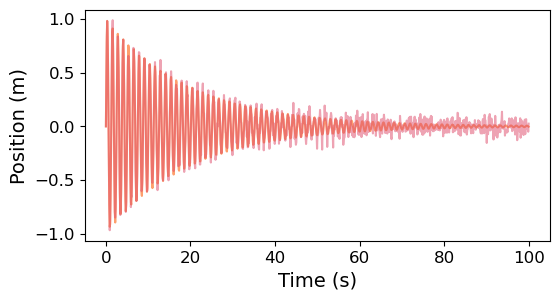

In [14]:
omega0 = 5
gamma = 0.1

tt, dtt = np.linspace(0, 100, 1000, retstep=True)
omega1 = np.sqrt((omega0)**2 - (gamma/2)**2)
theory = np.exp(-gamma/2 * tt) * np.sin(omega1 * tt)

np.random.seed(9)
noise = np.random.normal(0, 0.05, tt.size)
measurement = theory + noise

plt.plot(tt, theory)
plt.plot(tt, measurement, alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')

Use (extended) Kalman filter to track the motion

In [25]:
f = KalmanFilter(dim_x=4, dim_z=1)

dt = dtt  # time step

# Initial tate vector (z, v_z, omega**2, gamma)
# assume slightly off values
f.x = np.array([measurement[0], 0.8, 5**2, 0.11])
f.F = np.array([[1, dt, 0, 0],
                [-1*f.x[2]*dt, 1 - f.x[3]*dt, -1*f.x[0]*dt, -1*f.x[1]*dt],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
f.H = np.array([[1., 0., 0., 0.]])

f.P = np.diag([0.1, 0.1, 0.1, 0.1])
f.Q = np.array([[dt**4/4, dt**3/2, dt**2/2, dt**2/2],
                [dt**3/2, dt**2, dt, dt],
                [dt**2/2, dt, 1, 1],
                [dt**2/2, dt, 1, 1]]) * 1e-6
f.R = np.array([[0.05]])

In [26]:
nsteps = tt.size
zz_kf = np.empty((nsteps, 4))

zz_kf[0] = f.x
for i in range(nsteps-1):
    z = measurement[i+1]
    f.predict()
    f.update(z)

    zz_kf[i+1] = f.x

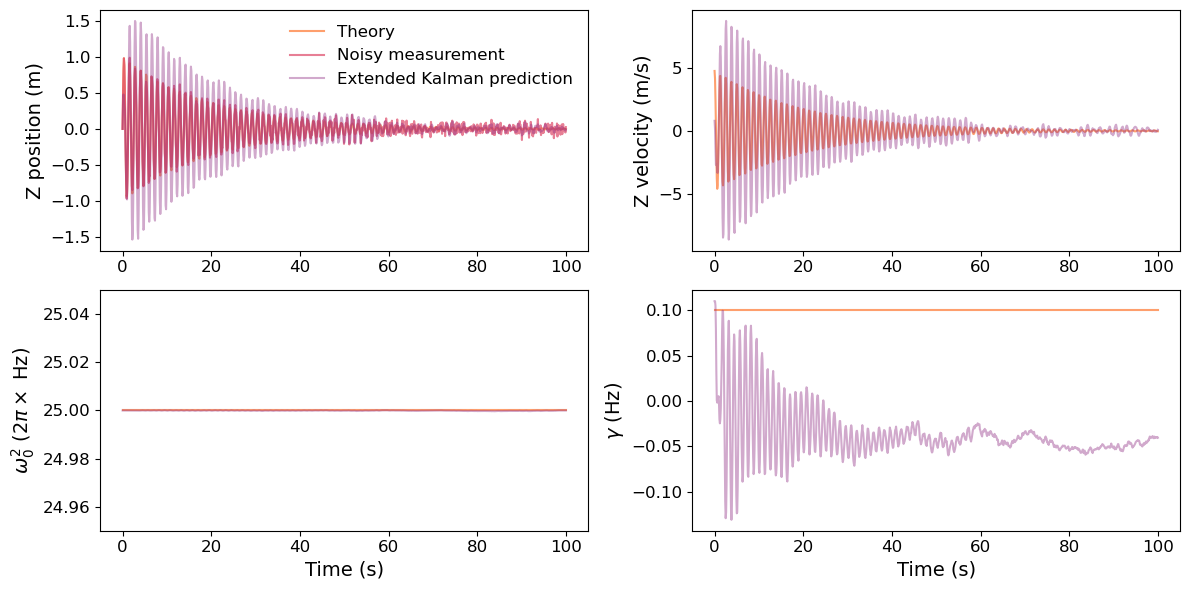

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

axes[0,0].plot(tt, theory, label='Theory')
axes[0,0].plot(tt, measurement, label='Noisy measurement', alpha=0.7)
axes[0,0].plot(tt, zz_kf.T[0], label='Extended Kalman prediction', alpha=0.4)

axes[0,1].plot(tt, np.gradient(theory, dtt))
axes[0,1].plot(tt, zz_kf.T[1], color=colors[2], alpha=0.4)

axes[1,0].plot(tt, np.full_like(tt, omega0**2))
axes[1,0].plot(tt, zz_kf.T[2], color=colors[2], alpha=0.4)
axes[1,0].set_ylim(24.95, 25.05)

axes[1,1].plot(tt, np.full_like(tt, gamma))
axes[1,1].plot(tt, zz_kf.T[3], color=colors[2], alpha=0.4)

axes[0,0].legend(frameon=False)
axes[0,0].set_ylabel('Z position (m)')
axes[0,1].set_ylabel('Z velocity (m/s)')
axes[1,0].set_ylabel(r'$\omega_0^2$ ($2 \pi \times$ Hz)')
axes[1,1].set_ylabel(r'$\gamma$ (Hz)')

for ax in axes[1]:
    ax.set_xlabel('Time (s)')

fig.tight_layout()

### Simulate sphere data with smoothly varying frequency and damping

First try numerically integrate a damped harmonic oscillator that doesn't drift. Just making sure that Runge-Kutta is working as expected.

In [51]:
def func_rk(t, y):
    omega = 5
    gamma = 0.1
    return (y[1], -1 * omega**2 * y[0] - gamma * y[1])

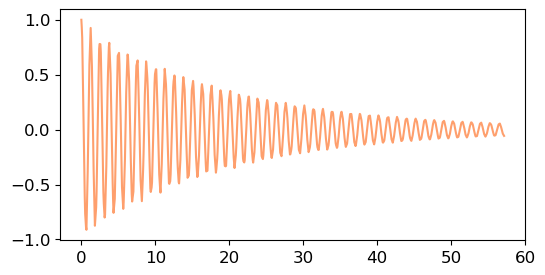

In [169]:
rk = RK45(func_rk, t0=0, y0=(1, 0), first_step=0.001, t_bound=100)

total_steps = 300
tt, zz, vv = [np.empty(total_steps) for i in range(3)]

for i in range(total_steps):
    tt[i] = rk.t
    zz[i], vv[i] = rk.y[0], rk.y[1]
    rk.step()

# Resample with a uniform timestep
tt_u, dt_u = np.linspace(tt[0], tt[-1], 1000, retstep=True)
zz_rk = np.interp(tt_u, tt, zz)

plt.plot(tt_u, zz_rk)

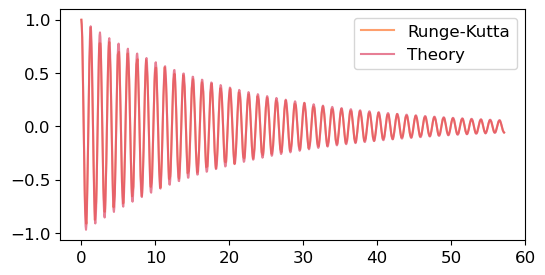

In [170]:
omega1 = np.sqrt((5)**2 - (0.1/2)**2)
theory = np.exp(-(0.1/2) * tt_u) * np.cos(omega1 * tt_u)

plt.plot(tt_u, zz_rk, label='Runge-Kutta')
plt.plot(tt_u, theory, label='Theory', alpha=0.7)
plt.legend()

Generate drift in frequency - start with a simple sinusoidal drift and keep damping constant.

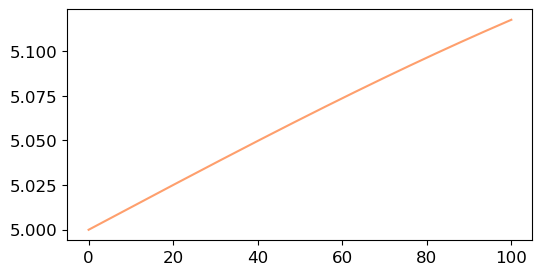

In [397]:
tt = np.linspace(0, 100, 10000)
omega_t = 5 + 0.2 * np.sin(0.001 * 2 * np.pi * tt)

fig, ax = plt.subplots(1, 1)
ax.plot(tt, omega_t)

In [398]:
def func_rk_drift(t, y, tt=tt, omega=omega_t, gamma=gamma_t):

    # Interpolation at time t
    omegat = np.interp(t, tt, omega)
    gammat = 0.01

    return (y[1], -1 * omegat**2 * y[0] - gammat * y[1])

rk = RK45(func_rk_drift, t0=0, y0=(0, 1), first_step=0.001, t_bound=100)

total_steps = 300
tt, zz, vv = [np.empty(total_steps) for i in range(3)]

for i in range(total_steps):
    tt[i] = rk.t
    zz[i], vv[i] = rk.y[0], rk.y[1]
    rk.step()

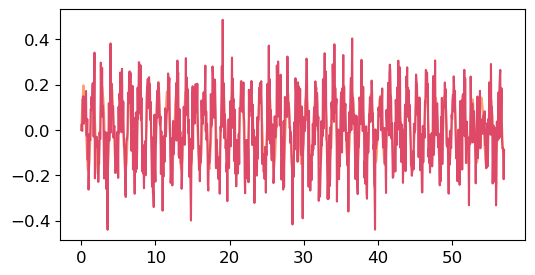

In [399]:
# Resample with a uniform timestep
tt_u, dt_u = np.linspace(tt[0], tt[-1], 1000, retstep=True)
zz_rk = np.interp(tt_u, tt, zz)

np.random.seed(9)
noise = np.random.normal(0, 0.1, tt_u.size)
measurement = zz_rk + noise

plt.plot(tt_u, zz_rk)
plt.plot(tt_u, measurement)

In [431]:
f = KalmanFilter(dim_x=4, dim_z=1)

dt = tt_u[1] - tt_u[0]  # time step
gamma0 = 0.01

# Initial tate vector (z, v_z, omega**2, force)
# assume slightly off values
f.x = np.array([measurement[0], 1, 5**2, 0])
f.F = np.array([[1, dt, 0, 0],
                [-1*f.x[2]*dt, 1 - gamma0*dt, -1*f.x[0]*dt, dt],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
f.H = np.array([[1., 0., 0., 0.]])

f.P = np.diag([0.01, 0.01, 0.01, 0.01])
# f.Q = np.array([[dt**4 / 4, dt**3 / 2, dt**2 / 2, dt**2 / 2],
#                 [dt**3 / 2, dt**2, dt, dt],
#                 [dt**2 / 2, dt, 1, 1],
#                 [dt**2 / 2, dt, 1, 1]]) * 0.0001
f.Q = Q_discrete_white_noise(4, dt=dt, var=1e-3)
f.R = np.array([[0.01]])

In [432]:
nsteps = tt_u.size
zz_kf = np.empty((nsteps, 4))

zz_kf[0] = f.x
for i in range(nsteps-1):
    z = measurement[i+1]
    f.predict()
    f.update(z)

    zz_kf[i+1] = f.x

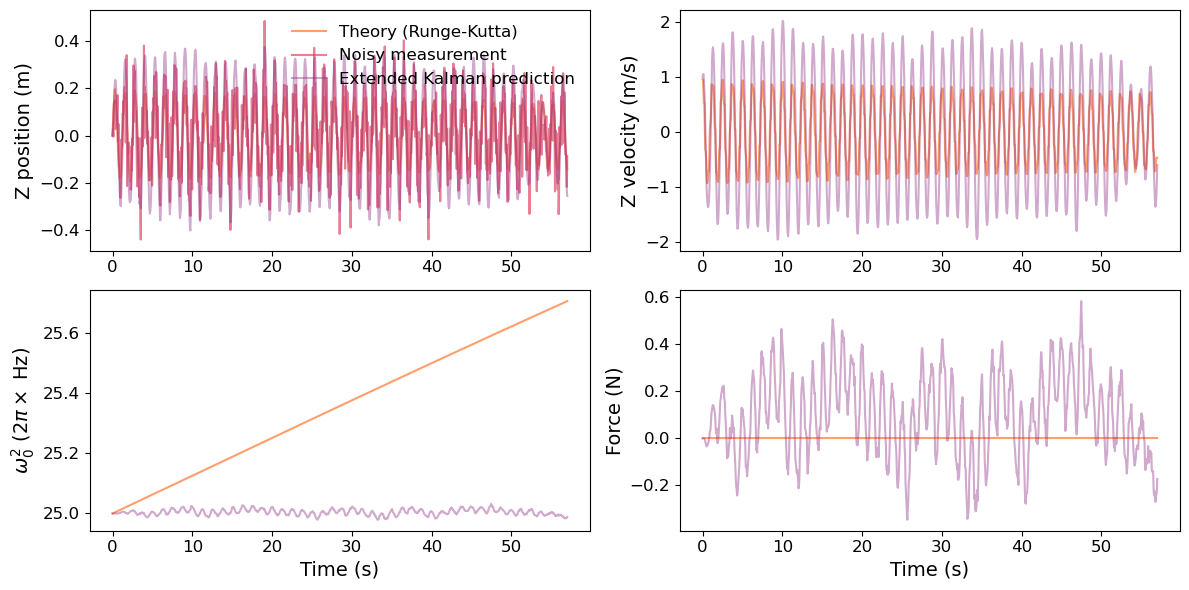

In [433]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

tt = tt_u
axes[0,0].plot(tt, zz_rk, label='Theory (Runge-Kutta)')
axes[0,0].plot(tt, measurement, label='Noisy measurement', alpha=0.7)
axes[0,0].plot(tt, zz_kf.T[0], label='Extended Kalman prediction', alpha=0.4)

axes[0,1].plot(tt, np.gradient(zz_rk, dt))
axes[0,1].plot(tt, zz_kf.T[1], color=colors[2], alpha=0.4)

axes[1,0].plot(tt, np.interp(tt, np.linspace(0, 100, 10000), omega_t)**2)
axes[1,0].plot(tt, zz_kf.T[2], color=colors[2], alpha=0.4)

axes[1,1].plot(tt, np.full_like(tt, 0))
axes[1,1].plot(tt, zz_kf.T[3], color=colors[2], alpha=0.4)

axes[0,0].legend(frameon=False)
axes[0,0].set_ylabel('Z position (m)')
axes[0,1].set_ylabel('Z velocity (m/s)')
axes[1,0].set_ylabel(r'$\omega_0^2$ ($2 \pi \times$ Hz)')
axes[1,1].set_ylabel(r'Force (N)')

for ax in axes[1]:
    ax.set_xlabel('Time (s)')

fig.tight_layout()

### Unscented Kalman filter

In [96]:
nstep = 10000
tt = np.linspace(0, 1, nstep)

Text(0, 0.5, 'Damping (Hz)')

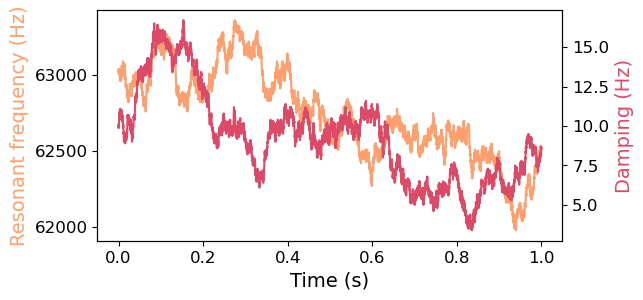

In [97]:
# Random walk in steps of 10 kHz
np.random.seed(12)
steps = 2 * np.random.randint(0, 1 + 1, nstep) - 1
omega = 2 * np.pi * (63000 + np.cumsum(steps) * 10)

# Damping in 0.1 Hz
np.random.seed(15)
steps = 2 * np.random.randint(0, 1 + 1, nstep) - 1
gamma = 10 + np.cumsum(steps) * 0.1

fig, ax = plt.subplots(1, 1)
ax.plot(tt, omega / (2 * np.pi), color=colors[0])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resonant frequency (Hz)', color=colors[0])

axt = ax.twinx()
axt.plot(tt, gamma, color=colors[1])
axt.set_ylabel('Damping (Hz)', color=colors[1])

In [98]:
nstep = 10000
tt = np.linspace(0, 1, nstep)

# Random walk in steps of 10 kHz
np.random.seed(12)
steps = 2 * np.random.randint(0, 1 + 1, nstep) - 1
omega = 2 * np.pi * (63000 + np.cumsum(steps) * 10)

# Damping in 0.1 Hz
np.random.seed(15)
steps = 2 * np.random.randint(0, 1 + 1, nstep) - 1
gamma = 10 + np.cumsum(steps) * 0.1

In [103]:
rk = RK45(func_rk_drift, t0=0, y0=(1, 0), first_step=1e-3, t_bound=1, vectorize=True)

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_22087/1698370920.py:1: UserWarning: The following arguments have no effect for a chosen solver: `vectorize`.
  rk = RK45(func_rk_drift, t0=0, y0=(1, 0), first_step=1e-3, t_bound=1, vectorize=True)


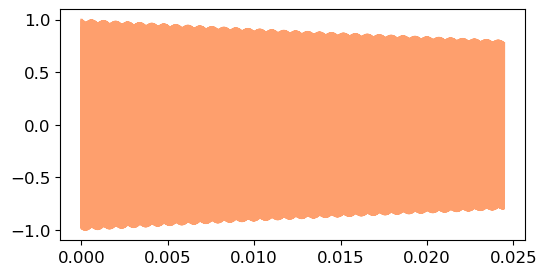

In [104]:
total_steps = 10000
tt_drift, xx_drift, vv_drift = [np.empty(total_steps) for i in range(3)]

for i in range(total_steps):
    tt_drift[i] = rk.t
    xx_drift[i], vv_drift[i] = rk.y[0], rk.y[1]
    rk.step()

plt.plot(tt_drift, xx_drift)

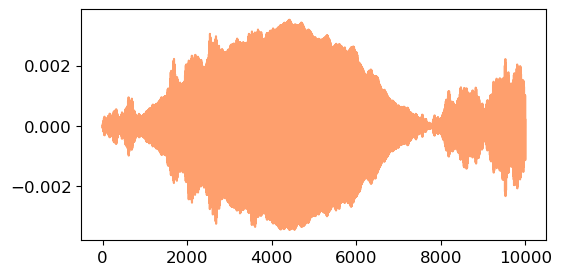

In [105]:
plt.plot(xx_drift-xx)

### Use extended Kalman filter

In [106]:
from filterpy.kalman import ExtendedKalmanFilter